<h2>Baseline models</h2>
<h4>Preprocessing tasks - </h4>
1) Unicode to UTF-8 decoding <br>
2) Remove punctuations and numbers <br>
3) Expand word contractions <br>
4) Lemmatization <br>

<h4>Feature extractions - </h4>
TF-IDF<br>
Word2Vec model
<h3> Import packages and set default preferences</h3>


In [67]:
import pandas as pd
import numpy as np
import os
import nltk
import string
import re
import pickle
import itertools
from nltk import pos_tag
from nltk import map_tag
from nltk.stem import WordNetLemmatizer
from unidecode import unidecode
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

import matplotlib.pyplot as plt
import seaborn as sns
import time
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
#import plotly.plotly as py
#import plotly.figure_factory as ff
from sklearn.manifold import TSNE
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc, accuracy_score
from sklearn.metrics import confusion_matrix, mean_squared_error
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.svm import LinearSVC
from gensim.models import KeyedVectors


# Set jupyter notebook preferences
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"
import warnings
warnings.filterwarnings('ignore')

sns.set_palette("hls")
%matplotlib inline

In [2]:
f = open("my_git_url.txt", "r")
git_dir = f.read()

In [3]:
df = pd.read_csv('finaldata.csv',encoding='utf-8')
df.head()
df.shape

,subreddit,text
0,conservative,Washington (CNN) Former FBI Director James Com...
1,conservative,NaN
2,conservative,Kanye West has been having a very Kanye West 2...
3,conservative,As a stoical Robert Bork sat before the Senate...
4,conservative,NaN


(17043, 2)

In [4]:
df.dropna(inplace=True)
df.shape

(16381, 2)

In [5]:
df = df[df['subreddit']!='socialism']
df = df.drop_duplicates()
df = df[(df['text'].str.len() > 1000) & (df['text'].str.len() < 10000)]

In [6]:
df = df.sample(frac=1).reset_index(drop=True)

In [59]:
df['subreddit'].shape
posts = df.text
posts.shape

(9325,)

(9325,)

In [109]:
df_new.to_csv('updated_data_binary.csv')

### Expanding word contractions in the text and encoding text to UTF-8

In [85]:
with open('expand_dict.pickle','rb') as f:
    expand_dict = pickle.load(f)

In [86]:
'''
expand_contractions takes text and search for word contractions from dictionary keys and expand it from
values from dictionary
'''
def expand_contractions(text, contraction_mapping=expand_dict):

    contractions_pattern = re.compile('({})'.format('|'.join(contraction_mapping.keys())), 
                                      flags=re.IGNORECASE|re.DOTALL)
    #print(contraction_mapping.keys())
    def expand_match(contraction):
        match = contraction.group(0)
        first_char = match[0]
        expanded_contraction = contraction_mapping.get(match)\
                                if contraction_mapping.get(match)\
                                else contraction_mapping.get(match.lower())                       
        expanded_contraction = first_char+expanded_contraction[1:]
        return expanded_contraction
        
    expanded_text = contractions_pattern.sub(expand_match, text)
    expanded_text = re.sub("'", "", expanded_text)
    return expanded_text

'\nexpand_contractions takes text and search for word contractions from dictionary keys and expand it from\nvalues from dictionary\n'

In [87]:
text_list = []
for post in posts:
    text_list.append(expand_contractions(post))

In [88]:
#encoding from Unicode to UTF-8 and storing into new list
encoded_list=[]
for post in text_list:
    encoded_list.append(unidecode(post))

### Word tokenization and remove punctuations

Tokenization and store cleaned tokens in the list

In [89]:
def word_clean_tokenize(text):
    tokens = nltk.word_tokenize(text)
    tokenlist = []
    for token in tokens:
        token = token.strip().lower()
        pattern = re.compile('[{}]'.format(re.escape(string.punctuation)))
        token = pattern.sub('',token)
        if not any(c.isdigit() for c in token):
            tokenlist.append(token)
    return tokenlist

In [90]:
#tokenize the text in the list and store cleaned tokens in the list
tokens = []
for text in encoded_list:
    tokens.append(word_clean_tokenize(text))

### Remove stop words and Lemmatizations

In [91]:
lemmatizer = WordNetLemmatizer()
lem_tokens=[]
stopword_list = nltk.corpus.stopwords.words('english')
for token_list in tokens:
    filter_list = []
    for token in token_list:
        if token not in stopword_list and token.strip():
            filter_list.append(token)
    lem_tokens.append(filter_list)
len(lem_tokens)

9325

In [158]:
with open('final_tokens_binary.pickle', 'wb') as fp:
    pickle.dump(lem_tokens, fp)

In [75]:
with open('final_tokens.pickle', 'rb') as fp:
    lem_tokens=pickle.load(fp)

In [97]:
a=[]
for t in lem_tokens:
    a.append(list(set(t))) 
len(a)        

9325

Encoding text label to intenger before feeding it to classification models

In [8]:
le = preprocessing.LabelEncoder()
df['subred_num']=le.fit_transform(df['subreddit'])

In [9]:
df['subred_num'].unique()

array([0, 1], dtype=int64)

In [10]:
subred_id_df = df[['subreddit', 'subred_num']].drop_duplicates().sort_values('subred_num')

In [11]:
subred_id_df.head()
subred_to_id = dict(subred_id_df.values)

,subreddit,subred_num
0,conservative,0
1,liberal,1


In [12]:
sorted(subred_to_id.items())

[('conservative', 0), ('liberal', 1)]

We cold try establishing classification accuracy on these data

<h3>TF-IDF Vectorizer and classification models</h3>

TF(t) = No of times t appears in a document/ Total number of terms in the doc<br>
IDF(t) = log_e(Total no of doc) / No of doc with term t in it<br><br>
Override the tokenizing phase and pass directly preprocessed tokens to the function

In [100]:
def identity_tokenizer(text):
    return text

tfidf = TfidfVectorizer(tokenizer=identity_tokenizer, stop_words='english', lowercase=False, 
                        sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1')    
features = tfidf.fit_transform(lem_tokens)

In [101]:
features.shape
labels = df.subred_num

(9325, 26060)

<h3>Plot TF-IDF Features using t-SNE</h3>
t-Distributed Stochastic Neighbor Embedding technique is useful for dimensionality reduction and visualizing high dimension data. <br>
<a>https://scikit-learn.org/stable/modules/generated/sklearn.manifold.TSNE.html</a><br>
<i>NOTE - Do not run this in local system unless machine have very large memmory. You might end up blowing your memory!</i>

In [ ]:
# Sampling a subset of  dataset because t-SNE is computationally expensive
SAMPLE_SIZE = int(len(features.toarray()) * 0.3)
np.random.seed(0)
indices = np.random.choice(range(len(features.toarray())), size=SAMPLE_SIZE, replace=False)          # Randomly select 30 % of samples
projected_features = TSNE(n_components=2, random_state=0).fit_transform(features.toarray()[indices]) # Array of all projected features of 30% of Randomly chosen samples 

Text(0.5, 1.0, 'tf-idf feature vector for each article, projected on 2 dimensions.')

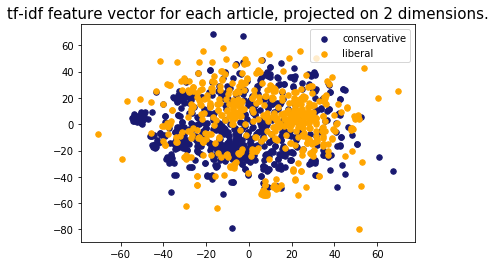

In [128]:
colors = ['midnightblue', 'orange']

# Find points belonging to each category and plot them
for subred, subred_id in sorted(subred_to_id.items()):
    points = projected_features[(labels[indices] == subred_id).values]
    plt.scatter(points[:, 0], points[:, 1], s=30, c=colors[subred_id], label=subred)
plt.title("tf-idf feature vector for each article, projected on 2 dimensions.",
          fontdict=dict(fontsize=15))
plt.legend()

Splitting the dataset into Train and test data. Training data would be TF-IDF vectors for the document and output is the ideology labels

In [102]:
X = features
y = labels
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [24]:
def plot_confusion_matrix(cm, classes,normalize=False,title='',cmap=plt.cm.Greys):
    """
    This function prints and plots the confusion matrix.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,fontsize=15)
    plt.yticks(tick_marks, classes,fontsize=15)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",fontsize=12,
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label',fontsize=15)
    plt.xlabel('Predicted label',fontsize=15)

This function is for estimating the performance of classification model in kfold cross validation by averaging multiple splits

In [25]:
def kfold_performance(classifier, X, y):
    kfold = KFold(n_splits=5, shuffle=True, random_state=42)
    scores=[]
    for train_index, test_index in kfold.split(X):
        
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y.iloc[train_index], y.iloc[test_index]
        classifier.fit(X_train, y_train)
        y_pred = classifier.predict(X_test)
        scores.append(accuracy_score(y_test, y_pred))
    return scores

Test the performance with set of classifiers beginning with Random Forest and Logistic regression

In [103]:
clf = {}
clf['LogisticRegression'] = LogisticRegression()
clf['Random Forest'] = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
clf['SVM'] = LinearSVC()
cv_df = pd.DataFrame()
model_tuples = []
for model in clf:
    scores = kfold_performance(clf[model], X, y)
    for fold, accuracy in enumerate(scores):
        model_tuples.append((model, fold, accuracy))
#print("Scores: {0}\nMean: {1:.3f}\nStd: {2:.3f}".format(scores, np.mean(scores), np.std(scores)))

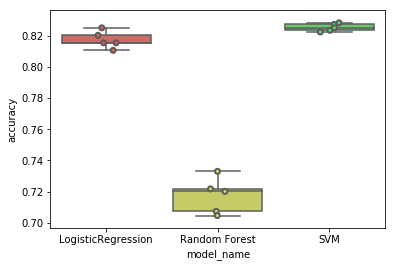

In [104]:
cv_df = pd.DataFrame(model_tuples, columns=['model_name', 'fold', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Looks like tree approach doenst work since it is marginally outperformed by other classifiers. 

Lets plot confusion matrix for Naive bayes and Logistic Regression to evaluate missclassification rate and how each class does with respect to others

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.80457227 0.19542773]
 [0.15533981 0.84466019]]


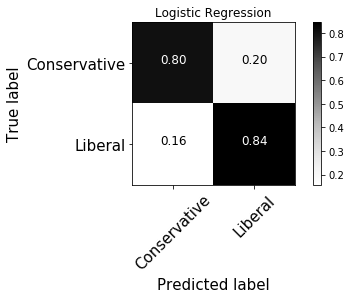

In [28]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Conservative','Liberal'], normalize=True,title='Logistic Regression')
plt.show()

LinearSVC(C=1.0, class_weight=None, dual=True, fit_intercept=True,
     intercept_scaling=1, loss='squared_hinge', max_iter=1000,
     multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
     verbose=0)

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.81858407 0.18141593]
 [0.15950069 0.84049931]]


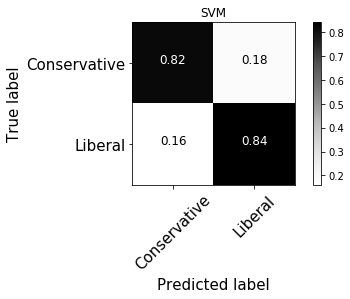

In [30]:
nb = LinearSVC()
nb.fit(X_train, y_train)
y_pred = nb.predict(X_test)
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Conservative','Liberal'], normalize=True,title='SVM')
plt.show()

Socialism still have high missclassification rate in both classifiers

<h3>Word2Vec embeddings and Classifiers</h3>

In [181]:
import gensim
from gensim.models import Word2Vec
from gensim.models import KeyedVectors

In [139]:
i=0
ls=[]
for tokens in lem_tokens:
    ls.append(gensim.models.doc2vec.TaggedDocument(tokens,[i]))
    i=i+1

In [90]:
GLOVE_DIR = 'glove_6b/glove.6B/'
embeddings_index = {}
f = open(os.path.join(GLOVE_DIR, 'glove.6B.100d.txt'), encoding='utf-8')
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))

Found 400000 word vectors.


Creating POS tagging to get the linguistic signal how words are used. We can later use only set of tags to train our algorithm

In [111]:
tagged_list = []
for text in lem_tokens:
    pos_tagged = pos_tag(text)
    tagged_pos = [(word, map_tag('en-ptb', 'universal', tag)) for word, tag in pos_tagged]
    tagged_list.append(tagged_pos)

In [162]:
with open('tagged_tokens_binary.pickle', 'wb') as handle:
    pickle.dump(tagged_list, handle, protocol=pickle.HIGHEST_PROTOCOL)

Load Google News Word2Vec pretrained model and add weigt to train vector for the token. If it doenst exist then add zero

In [70]:
def word2vec_embed(x_data, pos_filter):
    print('Loading Google news vector...')
    model = KeyedVectors.load_word2vec_format('googlenews_word2vec/GoogleNews-vectors-negative300.bin', binary=True)
    x_embedding = []
    
    print('Creating embeddings')
    for token_list in x_data:
        train_vec = np.zeros(300)
        for token in token_list:
            if token[1] in pos_filter:
            try:
                train_vec += model[token[0]]
            except KeyError:
                continue
        x_embedding.append(train_vec) 
    return np.array(x_embedding)        

In [112]:
pos_filter = ['NOUN','ADJ','VERB']
arr = word2vec_embed(posts_list,pos_filter)

Loading Google news vector...
Creating embeddings


In [113]:
model_embedded=PCA(n_components=2).fit_transform(arr)

Every article has weights assigned from google model

In [119]:
data = pd.DataFrame(data=arr)

In [120]:
data=data.join(df['subred_num'].reset_index().drop('index',axis=1))
data.head()

,0,1,2,3,4,5,6,7,8,9,...,291,292,293,294,295,296,297,298,299,subred_num
0,-41.666870,28.461975,4.495361,42.230225,-13.775024,-1.848846,-26.500214,-15.420898,-6.843384,-5.362732,...,-10.428223,-28.689148,38.587280,-13.054199,-52.871094,-31.532349,-6.297852,-20.033691,43.122803,0
1,-36.238098,24.106445,1.218994,32.348389,-16.954926,-1.540375,-18.922119,-11.374268,-8.532043,-2.579712,...,-6.221069,-23.804092,27.333618,-6.123413,-41.825684,-27.242798,-5.774536,-14.416748,32.758423,1
2,-104.142517,62.798035,-6.434509,93.664307,-48.855988,-4.448242,-63.247162,-34.322876,-24.522522,-15.009399,...,-27.572754,-70.494980,71.546021,-11.432861,-116.269531,-71.274292,-9.165283,-34.922974,93.559692,1
3,-54.954041,30.916016,-8.111206,35.274902,-19.896423,-4.101105,-20.647888,-17.915527,-3.081055,-2.800842,...,2.361328,-25.173203,28.293579,-10.293823,-55.489258,-31.078247,-9.182739,-14.481201,41.157349,0
4,-62.951355,47.612366,-0.653687,55.826416,-29.539703,-2.895325,-37.498444,-24.372803,-14.158081,-5.705872,...,-15.558594,-45.319016,56.557373,-17.909302,-79.711426,-47.733398,-13.835815,-23.935791,57.704224,0


Split the data into training and test data

In [121]:
X = data.iloc[:,:-1].values
y = data['subred_num']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

Again train models with k-fold cross validation taking word2vec vectors

In [122]:
clf = {}
clf['LogisticRegression'] = LogisticRegression() 
clf['Random Forest'] = RandomForestClassifier(n_estimators=200, max_depth=3, random_state=42)
clf['SVM'] = LinearSVC()
cv_df = pd.DataFrame()
model_tuples = []
for model in clf:
    scores = kfold_performance(clf[model], X, y)
    for fold, accuracy in enumerate(scores):
        model_tuples.append((model, fold, accuracy))

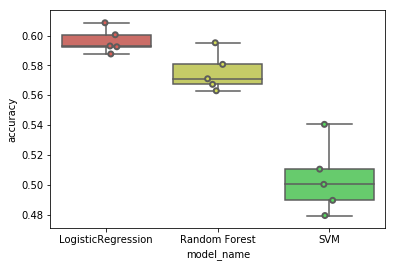

In [123]:
cv_df = pd.DataFrame(model_tuples, columns=['model_name', 'fold', 'accuracy'])
sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=5, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

Confusion matrix

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

<Figure size 432x288 with 0 Axes>

Normalized confusion matrix
[[0.69247788 0.30752212]
 [0.49930652 0.50069348]]


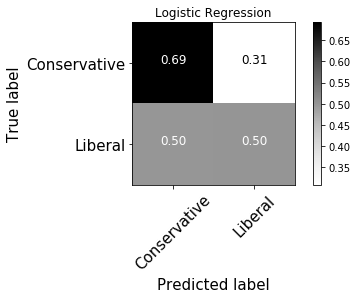

In [124]:
logit = LogisticRegression()
logit.fit(X_train, y_train)
y_pred = logit.predict(X_test)
cnf_matrix=confusion_matrix(y_test, y_pred)
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=['Conservative','Liberal'], normalize=True,title='Logistic Regression')
plt.show()